## Importações

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
# Necessário instalar o pmdarima no terminal com o comando: pip install pmdarima
from pmdarima.arima import auto_arima
from sklearn import metrics
import warnings 
warnings.filterwarnings('ignore')

## Carregar dados

Os arquivos CSV com os dados das APAC foram carregados e então alguns registros foram visualizados para verificar se a importação, criação do index e o parse da data ocorreu de forma correta. Também foram demonstradas algumas informações das séries, a fim de verificar as mesmas foram carregadas por completo e se existe algum valor importado fora do padrão ou nulo.

In [182]:
# Converter a coluna de competencia para data
date_parse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')

# Carregar os dados
base_filgrastim = pd.read_csv('./dados/filgrastim_300mcg.csv', parse_dates=['competencia'], index_col='competencia', date_parser=date_parse)
base_golimumabe = pd.read_csv('./dados/golimumabe_50mg.csv', parse_dates=['competencia'], index_col='competencia', date_parser=date_parse)
base_imiglucerase = pd.read_csv('./dados/imiglucerase_400u.csv', parse_dates=['competencia'], index_col='competencia', date_parser=date_parse)

In [183]:
# Visualização das cinco primeiras linhas
base_filgrastim.head()

,qtd_dispensada
competencia,
2019-01-01,3660
2019-02-01,3198
2019-03-01,1638
2019-04-01,1880
2019-05-01,4761


In [184]:
# Visualização das cinco primeiras linhas
base_golimumabe.head()

,qtd_dispensada
competencia,
2019-01-01,6411
2019-02-01,7169
2019-03-01,7133
2019-04-01,7325
2019-05-01,7397


In [185]:
# Visualização das cinco primeiras linhas
base_imiglucerase.head()

,qtd_dispensada
competencia,
2019-01-01,6152
2019-02-01,6487
2019-03-01,5784
2019-04-01,5804
2019-05-01,5630


In [186]:
# Verificar se existe algum valor nulo
base_filgrastim.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2019-01-01 to 2021-12-01
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   qtd_dispensada  36 non-null     int64
dtypes: int64(1)
memory usage: 576.0 bytes


In [187]:
# Verificar se existe algum valor nulo
base_golimumabe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2019-01-01 to 2021-12-01
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   qtd_dispensada  36 non-null     int64
dtypes: int64(1)
memory usage: 576.0 bytes


In [188]:
# Verificar se existe algum valor nulo
base_imiglucerase.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2019-01-01 to 2021-12-01
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   qtd_dispensada  36 non-null     int64
dtypes: int64(1)
memory usage: 576.0 bytes


## Visualizar série histórica


Abaixo é apresentada as séries históricas dos medicamentos incluídos nesse estudo, cada um contendo 36 meses de registro de dispensação. Tendo em vista que os medicamentos são distribuídos aos estados pelo Ministério da Saúde trimestralmente, e que a dispensação ao paciente pode ocorrer de forma antecipada em até três meses, foi plotado uma série histórica suavizada, agregando os dados por trimestre.

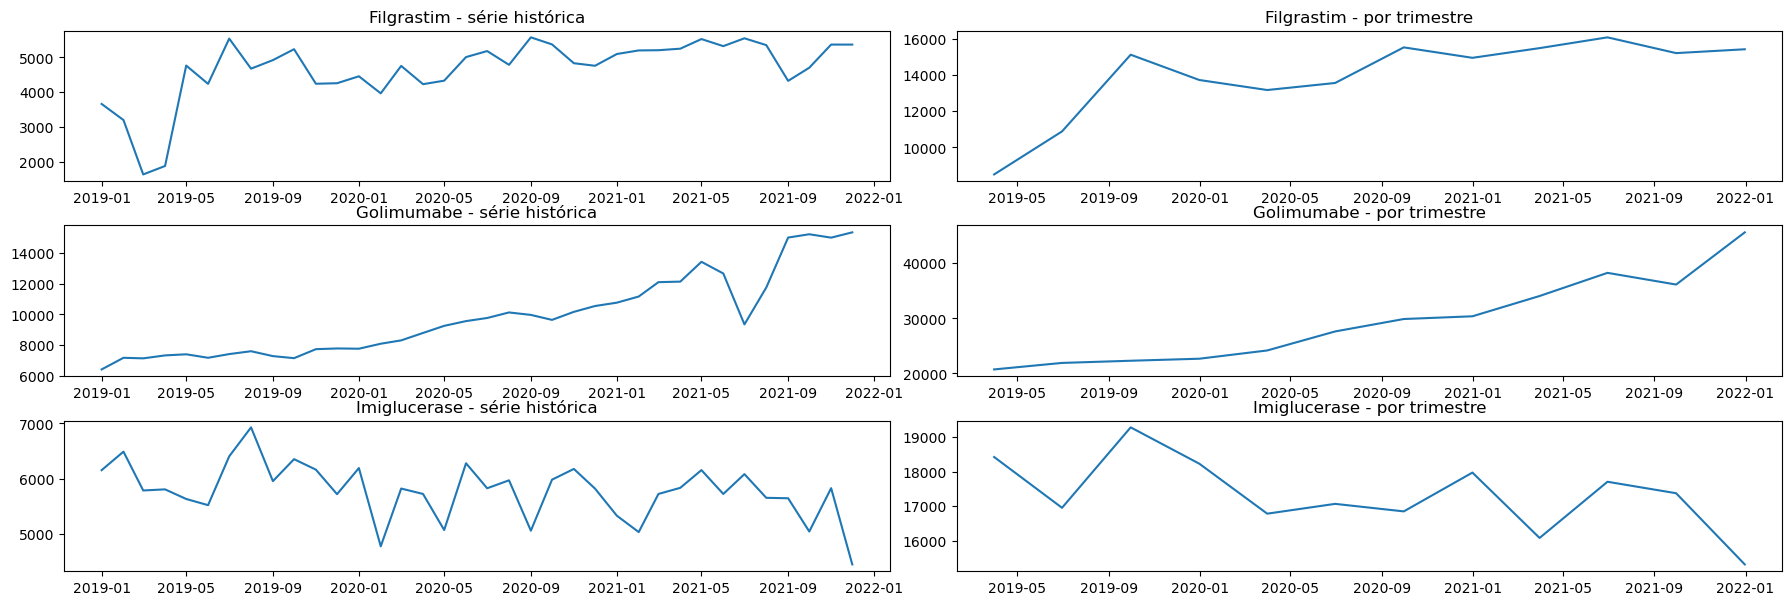

In [189]:
# Criar as séries temporais
ts_filgrastim = base_filgrastim['qtd_dispensada']
ts_golimumabe = base_golimumabe['qtd_dispensada']
ts_imiglucerase = base_imiglucerase['qtd_dispensada']

ts_filgrastim_trimestre = base_filgrastim.resample('Q').sum()
ts_golimumabe_trimestre = base_golimumabe.resample('Q').sum()
ts_imiglucerase_trimestre = base_imiglucerase.resample('Q').sum()

# Plotar os gráficos das séries temporais   
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18, 6))
fig.tight_layout()
ax[0,0].plot(ts_filgrastim)
ax[0,0].set_title("Filgrastim - série histórica")
ax[0,1].plot(ts_filgrastim_trimestre)
ax[0,1].set_title("Filgrastim - por trimestre")
ax[1,0].plot(ts_golimumabe)
ax[1,0].set_title("Golimumabe - série histórica")
ax[1,1].plot(ts_golimumabe_trimestre)
ax[1,1].set_title("Golimumabe - por trimestre")
ax[2,0].plot(ts_imiglucerase)
ax[2,0].set_title("Imiglucerase - série histórica")
ax[2,1].plot(ts_imiglucerase_trimestre)
ax[2,1].set_title("Imiglucerase - por trimestre")

plt.show()

## Arima

### Decomposição

O Arima permite decompocor uma série temporal para que possa ser analisado quatro padrões: tendência, variações cíclicas, sazonalidade e variações irregulares. 

Text(0.5, 1.0, 'Imiglucerase - Resíduo')

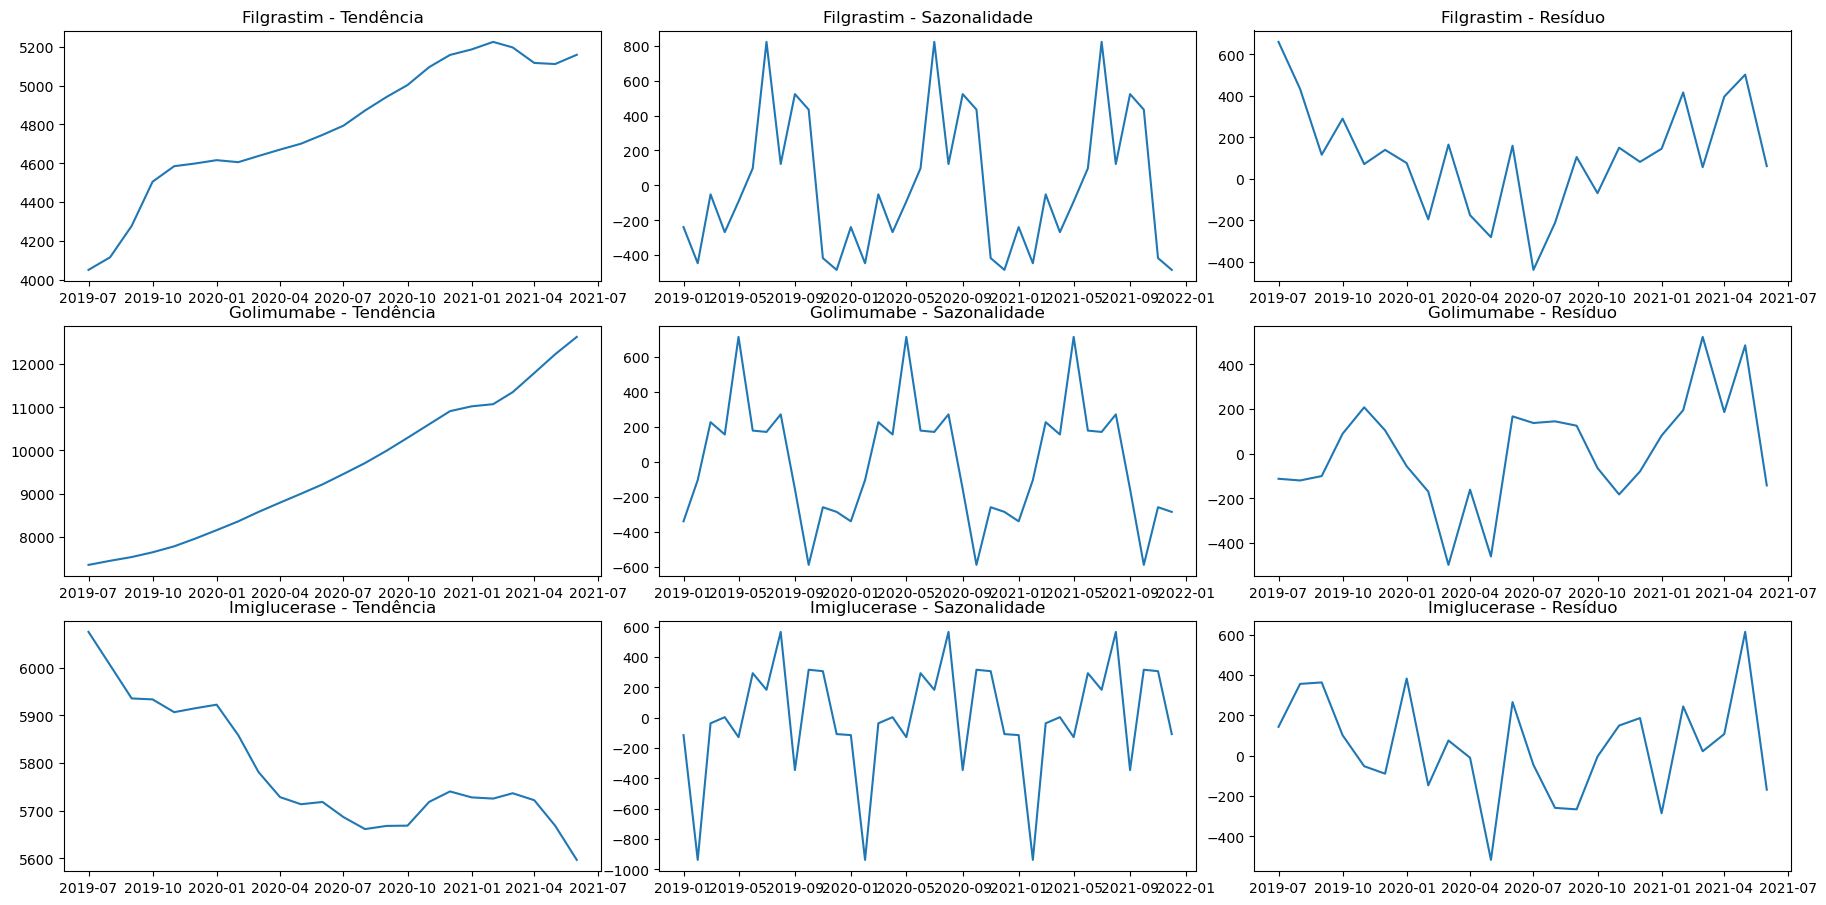

In [190]:
# Preparação para decompor a série temporal
decoposicao_filgratim = seasonal_decompose(base_filgrastim)
decoposicao_golimumabe = seasonal_decompose(base_golimumabe)
decoposicao_imiglucerase = seasonal_decompose(base_imiglucerase)

# Obter a tendência da série temporal
tendencia_filgratim = decoposicao_filgratim.trend
tendencia_golimumabe = decoposicao_golimumabe.trend
tendencia_imiglucerase = decoposicao_imiglucerase.trend

# Obter a sozonalidade da série temporal
sazonal_filgratim = decoposicao_filgratim.seasonal
sazonal_golimumabe = decoposicao_golimumabe.seasonal
sazonal_imiglucerase = decoposicao_imiglucerase.seasonal

# Obter o resíduo da série temporal
resid_filgratim = decoposicao_filgratim.resid
resid_golimumabe = decoposicao_golimumabe.resid
resid_imiglucerase = decoposicao_imiglucerase.resid

# Plotar os gráficos das decomposições
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(18, 9))
fig.tight_layout()
ax[0,0].plot(tendencia_filgratim)
ax[0,0].set_title("Filgrastim - Tendência")
ax[0,1].plot(sazonal_filgratim)
ax[0,1].set_title("Filgrastim - Sazonalidade")
ax[0,2].plot(resid_filgratim)
ax[0,2].set_title("Filgrastim - Resíduo")
ax[1,0].plot(tendencia_golimumabe)
ax[1,0].set_title("Golimumabe - Tendência")
ax[1,1].plot(sazonal_golimumabe)
ax[1,1].set_title("Golimumabe - Sazonalidade")
ax[1,2].plot(resid_golimumabe)
ax[1,2].set_title("Golimumabe - Resíduo")
ax[2,0].plot(tendencia_imiglucerase)
ax[2,0].set_title("Imiglucerase - Tendência")
ax[2,1].plot(sazonal_imiglucerase)
ax[2,1].set_title("Imiglucerase - Sazonalidade")
ax[2,2].plot(resid_imiglucerase)
ax[2,2].set_title("Imiglucerase - Resíduo")

### Estacionalidade
Por meio do Teste de Dickey-Fuller Aumentado (ADF) foi verificado se as séries temporais são estacionárias ou não. Caso o ADF retorne o p-value inferior ao nível de confiança de 0.05 será considerado que a série é estacionária.  
Verificou-se que apenas o medicamento Imiglucerase 400U possui uma série estacionária. Assim, o modelo Arima para esse medicamento possuirá o termo de diferenciação (d) igual a 0. Para os demais medicamentos será preciso realizar a decomposição para identificar o valor d.

In [191]:
# Teste de Dickey-Fuller Aumentado (ADF) para verificar se a série temporal é estacionária
adf_filgrastim = adfuller(base_filgrastim)
print('Teste ADF')
print('Teste Estatístico: {:.4f}'.format(adf_filgrastim[0]))
print('p-value: {:.4f}'.format(adf_filgrastim[1]))
print('Valores Críticos:')
for key, value in adf_filgrastim[4].items():
	print('\t{}: {:.4f}'.format(key, value))
if adf_filgrastim[1] > 0.05:
    print("Hipotese nula aceita. Série não estacionária.")
else:
    print("Hipotese nula rejeitada. Série estacionária.")

Teste ADF
Teste Estatístico: -2.6991
p-value: 0.0742
Valores Críticos:
	1%: -3.6327
	5%: -2.9485
	10%: -2.6130
Hipotese nula aceita. Série não estacionária.


In [192]:
# Teste de Dickey-Fuller Aumentado (ADF) para verificar se a série temporal é estacionária
adf_golimumabe = adfuller(base_golimumabe)
print('Teste ADF')
print('Teste Estatístico: {:.4f}'.format(adf_golimumabe[0]))
print('p-value: {:.4f}'.format(adf_golimumabe[1]))
print('Valores Críticos:')
for key, value in adf_golimumabe[4].items():
	print('\t{}: {:.4f}'.format(key, value))
if adf_golimumabe[1] > 0.05:
    print("Hipotese nula aceita. Série não estacionária.")
else:
    print("Hipotese nula rejeitada. Série estacionária.")

Teste ADF
Teste Estatístico: 1.3644
p-value: 0.9969
Valores Críticos:
	1%: -3.7112
	5%: -2.9812
	10%: -2.6301
Hipotese nula aceita. Série não estacionária.


In [193]:
# Teste de Dickey-Fuller Aumentado (ADF) para verificar se a série temporal é estacionária
adf_imiglucese = adfuller(base_imiglucerase)
print('Teste ADF')
print('Teste Estatístico: {:.4f}'.format(adf_imiglucese[0]))
print('p-value: {:.4f}'.format(adf_imiglucese[1]))
print('Valores Críticos:')
for key, value in adf_imiglucese[4].items():
	print('\t{}: {:.4f}'.format(key, value))
if adf_imiglucese[1] > 0.05:
    print("Hipotese nula aceita. Série não estacionária.")
else:
    print("Hipotese nula rejeitada. Série estacionária.")

Teste ADF
Teste Estatístico: -4.6588
p-value: 0.0001
Valores Críticos:
	1%: -3.6327
	5%: -2.9485
	10%: -2.6130
Hipotese nula rejeitada. Série estacionária.


### Diferenciação

Como foi verificado que as séries temporais para os medicamentos Filgrastim 300mcg e Golimumabe 50mg não são estacionárias, será necessário realizar a diferenciação para remover a tendência e sazonalidade dos dados originais.  
Foi verificado que apenas uma diferenciação foi suficiente para tornar as séries estacionárias, sendo que este achado foi corroborado com a realização do teste ADF. Assim, ambos os medicamentos terão o valor d igual a 1.

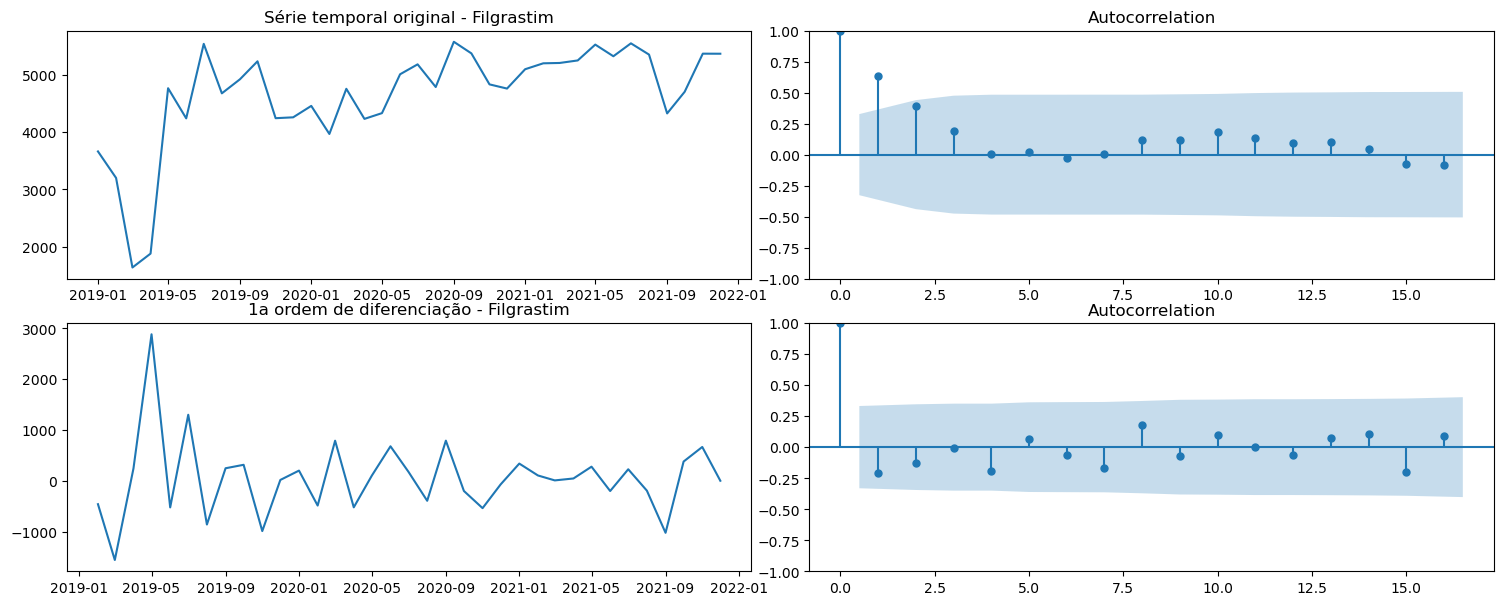

In [194]:
# Série original
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
fig.tight_layout()

axes[0, 0].plot(base_filgrastim.qtd_dispensada); axes[0, 0].set_title('Série temporal original - Filgrastim')
plot_acf(base_filgrastim.qtd_dispensada, ax=axes[0, 1])

# 1a diferenciação
axes[1, 0].plot(base_filgrastim.qtd_dispensada.diff()); axes[1, 0].set_title('1a ordem de diferenciação - Filgrastim')
plot_acf(base_filgrastim.qtd_dispensada.diff().dropna(), ax=axes[1, 1])

plt.show()

In [195]:
# Teste de Dickey-Fuller Aumentado (ADF) para verificar se a série temporal ficou estacionária após a diferenciação
adf_imiglucese = adfuller(base_imiglucerase.qtd_dispensada.diff().dropna())
print('Teste ADF')
print('Teste Estatístico: {:.4f}'.format(adf_imiglucese[0]))
print('p-value: {:.4f}'.format(adf_imiglucese[1]))
print('Valores Críticos:')
for key, value in adf_imiglucese[4].items():
	print('\t{}: {:.4f}'.format(key, value))
if adf_imiglucese[1] > 0.05:
    print("Hipotese nula aceita. Série não estacionária.")
else:
    print("Hipotese nula rejeitada. Série estacionária.")

Teste ADF
Teste Estatístico: -9.8379
p-value: 0.0000
Valores Críticos:
	1%: -3.6392
	5%: -2.9512
	10%: -2.6144
Hipotese nula rejeitada. Série estacionária.


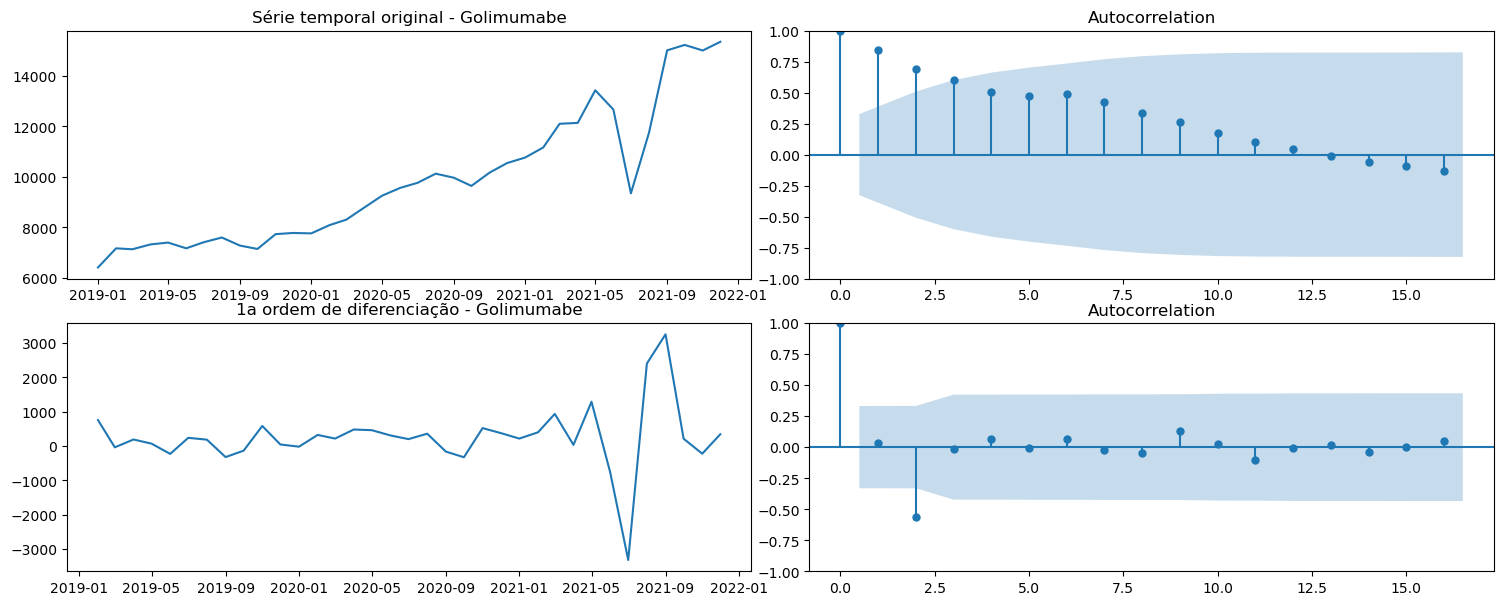

In [196]:
# Série original
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
fig.tight_layout()

axes[0, 0].plot(base_golimumabe.qtd_dispensada); axes[0, 0].set_title('Série temporal original - Golimumabe')
plot_acf(base_golimumabe.qtd_dispensada, ax=axes[0, 1])

# 1a diferenciação
axes[1, 0].plot(base_golimumabe.qtd_dispensada.diff()); axes[1, 0].set_title('1a ordem de diferenciação - Golimumabe')
plot_acf(base_golimumabe.qtd_dispensada.diff().dropna(), ax=axes[1, 1])

plt.show()

In [197]:
# Teste de Dickey-Fuller Aumentado (ADF) para verificar se a série temporal ficou estacionária após a diferenciação
adf_imiglucese = adfuller(base_imiglucerase.qtd_dispensada.diff().dropna())
print('Teste ADF')
print('Teste Estatístico: {:.4f}'.format(adf_imiglucese[0]))
print('p-value: {:.4f}'.format(adf_imiglucese[1]))
print('Valores Críticos:')
for key, value in adf_imiglucese[4].items():
	print('\t{}: {:.4f}'.format(key, value))
if adf_imiglucese[1] > 0.05:
    print("Hipotese nula aceita. Série não estacionária.")
else:
    print("Hipotese nula rejeitada. Série estacionária.")

Teste ADF
Teste Estatístico: -9.8379
p-value: 0.0000
Valores Críticos:
	1%: -3.6392
	5%: -2.9512
	10%: -2.6144
Hipotese nula rejeitada. Série estacionária.


Para identificar o melhor valor para o parâmetro P foi utilizada a atocorrelação parcial (PACF). Pela avaliação visual identificou que os melhores valores são 0, 0 e 1 para o Filgrastim 300mcg, Golimumabe 50mg e Imiglucerase 400U, respectivamente.

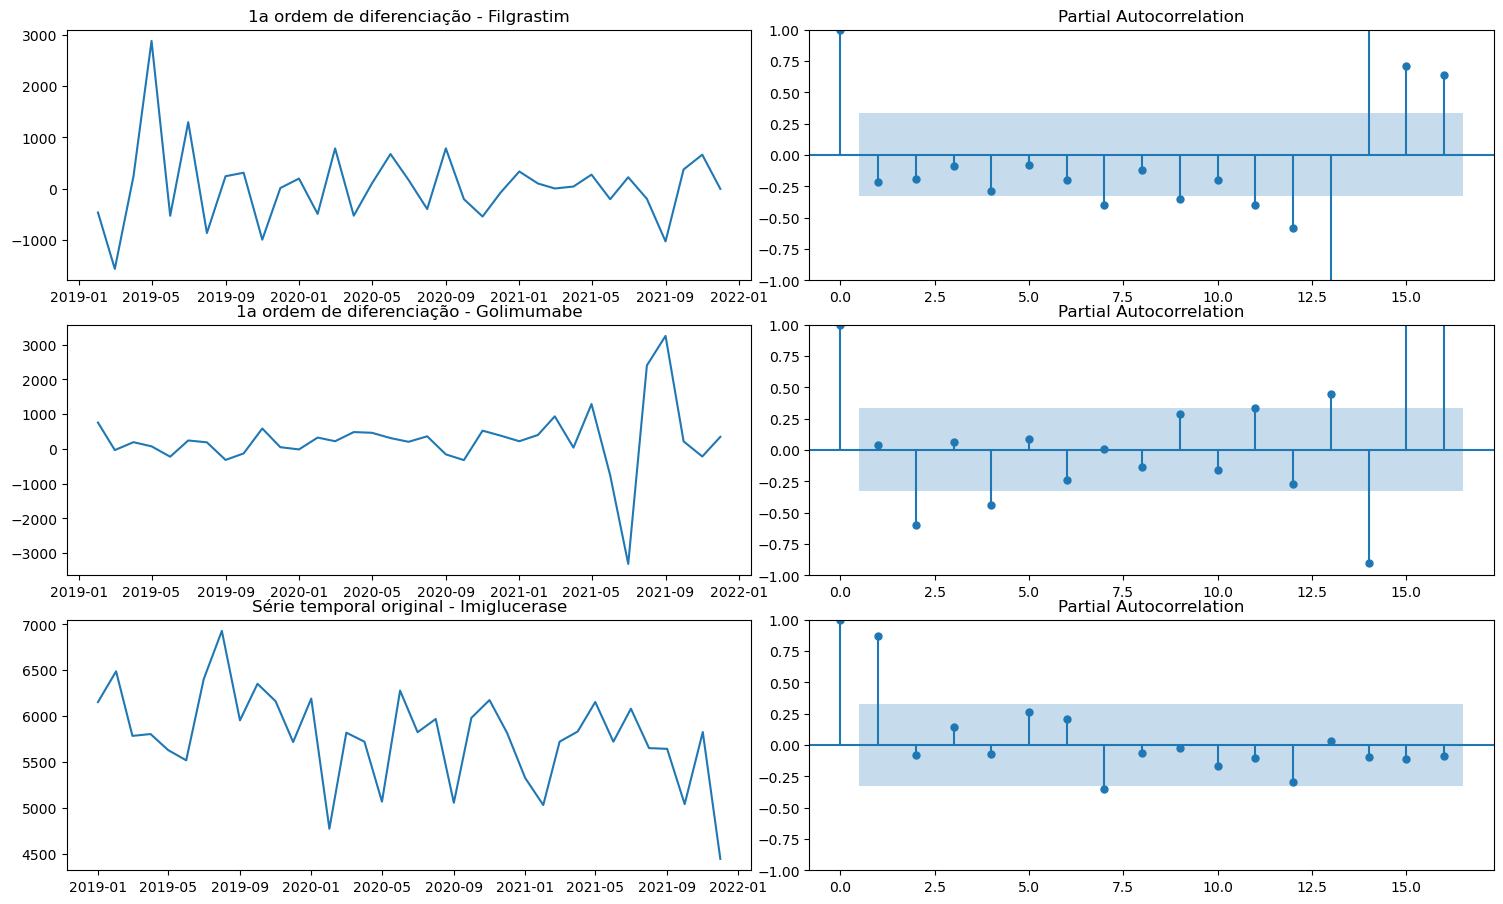

In [198]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))
fig.tight_layout()

# PACF Filgrastim
axes[0, 0].plot(base_filgrastim.qtd_dispensada.diff()); axes[0, 0].set_title('1a ordem de diferenciação - Filgrastim')
plot_pacf(base_filgrastim.qtd_dispensada.diff().dropna(), ax=axes[0, 1])

# PACF Golimumabe
axes[1, 0].plot(base_golimumabe.qtd_dispensada.diff()); axes[1, 0].set_title('1a ordem de diferenciação - Golimumabe')
plot_pacf(base_golimumabe.qtd_dispensada.diff().dropna(), ax=axes[1, 1])

# PACF Imiglucerase
axes[2, 0].plot(base_imiglucerase.qtd_dispensada); axes[2, 0].set_title('Série temporal original - Imiglucerase')
plot_pacf(base_golimumabe.qtd_dispensada.dropna(), ax=axes[2, 1])

plt.show()

Por fim, restou identificar o melhor valor para o parâmetro Q e para isso foi utilizado o ACF. Após análise verificou-se que o valor Q deve ser 1 para todos os medicamentos.
Como o ACF ainda não tinha sido obtido para o Imiglucerase, o mesmo foi plotado abaixo.

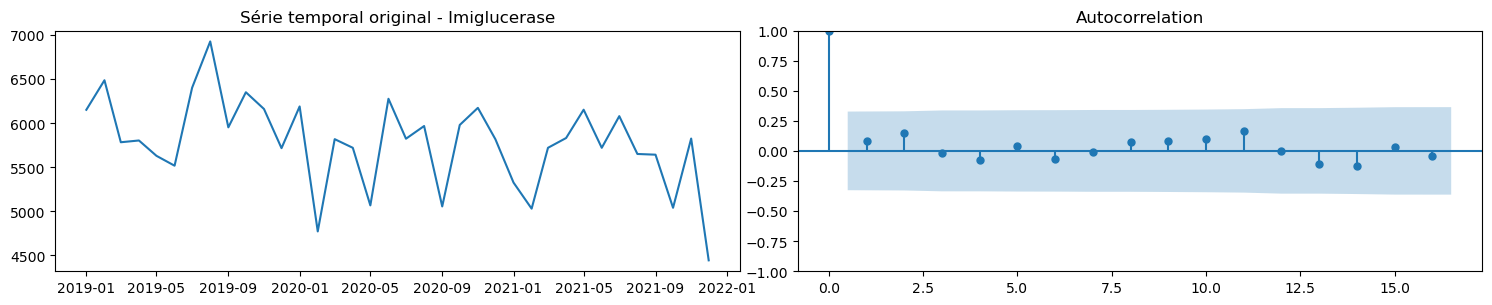

In [199]:
# ACF para o Imiglucerase
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
fig.tight_layout()

axes[0].plot(base_imiglucerase.qtd_dispensada); axes[0].set_title('Série temporal original - Imiglucerase')
plot_acf(base_imiglucerase.qtd_dispensada.dropna(), ax=axes[1])

plt.show()

Dessa forma, foram obtidos os seguintes valores iniciais para realizar as previsões no Arima:
| Medicamento                       | p | d | q |
|-----------------------------------|---|---|---|
| Filgrastim 300mcg injetável       | 0 | 1 | 1 |
| Golimumabe 50mg solução injetável | 0 | 1 | 1 |
| Imiglucerase 400U injetável       | 1 | 0 | 1 |

### Criar as bases de treino (80%) e teste (20%).

In [200]:
train_filgrastim = base_filgrastim[:28]
test_filgrastim = base_filgrastim[28:]
#train_filgrastim
#test_filgrastim

In [201]:
train_golimumabe = base_golimumabe[:28]
test_golimumabe = base_golimumabe[28:]
#train_golimumabe.shape
#test_golimumabe.shape

In [202]:
train_imiglucerase = base_imiglucerase[:28]
test_imiglucerase = base_imiglucerase[28:]
#train_imiglucerase.shape
#test_imiglucerase.shape

### Treino com parâmetros selecionados

Segue abaixo os treinos realizados para cada medicamento no Arima utilizando os parâmetros p, d, q selecionados anteriormente.

In [203]:
# Treino do modelo
model_filgrastim = ARIMA(train_filgrastim, order=(0, 1, 1))  
fitted_filgrastim = model_filgrastim.fit()  

# Visualizar resultado do treino
print(fitted_filgrastim.summary())

                               SARIMAX Results                                
Dep. Variable:         qtd_dispensada   No. Observations:                   28
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -217.750
Date:                Tue, 28 Mar 2023   AIC                            439.501
Time:                        16:42:17   BIC                            442.092
Sample:                    01-01-2019   HQIC                           440.271
                         - 04-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3826      0.190     -2.011      0.044      -0.755      -0.010
sigma2       5.99e+05   1.08e+05      5.557      0.000    3.88e+05     8.1e+05
Ljung-Box (L1) (Q):                   0.04   Jarque-

In [204]:
# Treino do modelo
model_golimimabe = ARIMA(train_golimumabe, order=(0, 1, 1))  
fitted_golimimabe = model_golimimabe.fit()  

# Visualizar resultado do treino
print(fitted_golimimabe.summary())

                               SARIMAX Results                                
Dep. Variable:         qtd_dispensada   No. Observations:                   28
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -194.049
Date:                Tue, 28 Mar 2023   AIC                            392.097
Time:                        16:42:17   BIC                            394.689
Sample:                    01-01-2019   HQIC                           392.868
                         - 04-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6763      0.200      3.378      0.001       0.284       1.069
sigma2        1.1e+05   3.53e+04      3.113      0.002    4.07e+04    1.79e+05
Ljung-Box (L1) (Q):                   3.31   Jarque-

In [205]:
# Treino do modelo
model_imiglucerase = ARIMA(train_imiglucerase, order=(1, 0, 1))  
fitted_imiglucerase = model_imiglucerase.fit()  

# Visualizar resultado do treino
print(fitted_imiglucerase.summary())

                               SARIMAX Results                                
Dep. Variable:         qtd_dispensada   No. Observations:                   28
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -212.130
Date:                Tue, 28 Mar 2023   AIC                            432.260
Time:                        16:42:17   BIC                            437.589
Sample:                    01-01-2019   HQIC                           433.889
                         - 04-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5838.7592    108.846     53.642      0.000    5625.424    6052.094
ar.L1          0.2580      2.507      0.103      0.918      -4.656       5.172
ma.L1         -0.1527      2.509     -0.061      0.9

O modelo Arima foi treinado e então foi observado os valores das métricas Akaike Information Criterion (AIC) e Bayesian Information Criteria (BIC). O objetivo é reduzir os valores desses scores para melhorar o modelo. Isso pode ser realiazdo manualmente, alterando os parâmetros do Arima (p, d, q) e procedendo com novos testes, ou de forma sistemática pela biblioteca `auto_arima`. O `auto_arima` seleciona os melhores parâmetros para o Arima pela avaliação do AIC. Adiconalmente, com esta biblioteca é possível testar valores para o SARIMA, verificando se o modelo melhora com a adição de parâmetros sazonais. Conforme avaliação visual realizada na decomposição das séries temporais, todos os medicamentos possuem um comportamento sazonal.  
Objetivando melhorar o modelo cada medicamento foi testado com o `auto_arima` com a adição de parâmetros sazonais e então realizada a comparação com os valores obtidos inicialmente.

### Treino auto_arima

In [206]:
# Utilizar o auto_arima para identificar os melhores parametros para o Arima. A escolha será pelo menor AIC.
stepwise_model_filgrastim = auto_arima(train_filgrastim, start_p=1, start_q=1, max_p=6, max_q=6, m=12, start_P=0, seasonal=True, d=1, D=1, trace=False, error_action='ignore', suppress_warnings=True, stepwise=False)

# #exibir o sumário com as métricas encontradas
stepwise_model_filgrastim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   28
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -119.614
Date:                             Tue, 28 Mar 2023   AIC                            247.227
Time:                                     16:43:07   BIC                            250.060
Sample:                                 01-01-2019   HQIC                           247.197
                                      - 04-01-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6138      0.352     -1.743      0.081      -1.304       0.077
ar.S.L12      -1.1288      0.372     -3.034      0.002      -1.858      -0.400
ar.S.L24      -0.9962      0.002   -464.611      0.000      -1.000      -0.992
sigma2      4989.3265   2.18e-07   2.29e+10      0.000    4989.327    4989.327
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.89
Prob(Q):                              0.89   Prob(JB):                         0.64
Heteroskedasticity (H):               0.15   Skew:                            -0.43
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.21e+28. Standard errors may be unstable.
"""

In [207]:
# Utilizar o auto_arima para identificar os melhores parametros para o Arima. A escolha será pelo menor AIC.
stepwise_model_golimumabe = auto_arima(train_golimumabe, start_p=1, start_q=1, max_p=6, max_q=6, m=12, start_P=0, seasonal=True, d=1, D=1, trace=False, error_action='ignore', suppress_warnings=True, stepwise=False)

# #exibir o sumário com as métricas encontradas
stepwise_model_golimumabe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   28
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -108.851
Date:                            Tue, 28 Mar 2023   AIC                            219.702
Time:                                    16:43:40   BIC                            220.410
Sample:                                01-01-2019   HQIC                           219.694
                                     - 04-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.171e+05   5.28e+04      2.218      0.027    1.36e+04    2.21e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                 0.31
Prob(Q):                              0.36   Prob(JB):                         0.86
Heteroskedasticity (H):               1.14   Skew:                            -0.27
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [208]:
# Utilizar o auto_arima para identificar os melhores parametros para o Arima. A escolha será pelo menor AIC.
stepwise_model_imiglucerase = auto_arima(train_imiglucerase, start_p=1, start_q=1, max_p=6, max_q=6, m=12, start_P=0, seasonal=True, d=1, D=1, trace=False, error_action='ignore', suppress_warnings=True, stepwise=False)

# #exibir o sumário com as métricas encontradas
stepwise_model_imiglucerase.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   28
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -120.259
Date:                             Tue, 28 Mar 2023   AIC                            248.519
Time:                                     16:44:26   BIC                            251.351
Sample:                                 01-01-2019   HQIC                           248.489
                                      - 04-01-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9850      3.693     -0.267      0.790      -8.223       6.253
ar.S.L12      -0.5208      0.639     -0.815      0.415      -1.773       0.732
ar.S.L24      -0.9939      0.022    -45.698      0.000      -1.037      -0.951
sigma2      4391.0067   6.51e-06   6.75e+08      0.000    4391.007    4391.007
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 5.21
Prob(Q):                              0.84   Prob(JB):                         0.07
Heteroskedasticity (H):               0.15   Skew:                            -1.21
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.2e+27. Standard errors may be unstable.
"""

### Seleção do melhor modelo

Realizada a avaiação com o `auto_arima`, foi comparado os valores para o AIC. Segue abaixo a tabela com o resumo dos dados obtidos:

Treinamento manual:
| Medicamento                       | p | d | q | AIC     |
|-----------------------------------|---|---|---|---------|
| Filgrastim 300mcg injetável       | 0 | 1 | 1 | 440.834 |
| Golimumabe 50mg solução injetável | 0 | 1 | 1 | 392.097 |
| Imiglucerase 400U injetável       | 1 | 0 | 1 | 432.260 |

Auto_arima com sazonalidade:
| Medicamento                       | Sarima                 | AIC     |
|-----------------------------------|------------------------|---------|
| Filgrastim 300mcg injetável       | 0, 1, 1 x 2, 1, [], 12 | 247.227 |
| Golimumabe 50mg solução injetável | 0, 1, 0 x 0, 1, 0, 12  | 219.702 |
| Imiglucerase 400U injetável       | 0, 1, 1 x 2, 1, [], 12 | 248.519 |

Conforme pode ser verificado, todos os modelos criados pelo `auto_arima` possuem o AIC consideravelmente menores. Assim, esses modelos serão utilizados para predição.

## Avaliação modelo

Antes de proceder com a predição é necessário avaliar os resíduos dos modelos. Espera-se obter um ruído branco, conforme descrito abaixo:  
1- A média dos resíduos deve estar próximo de zero, com os valores distribuídos aleatoriamente acima e abaixo da média;  
2- A densidade deve estimar uma distribuição normal;  
3- Gráfico QQ deve confirmar uma distribuição normal;  
4- O ACF não deve apresentar correlação.  
  
Conforme pode ser visto abaixo, todos os modelos possuem resíduos dentro dos padrões aceitáveis.

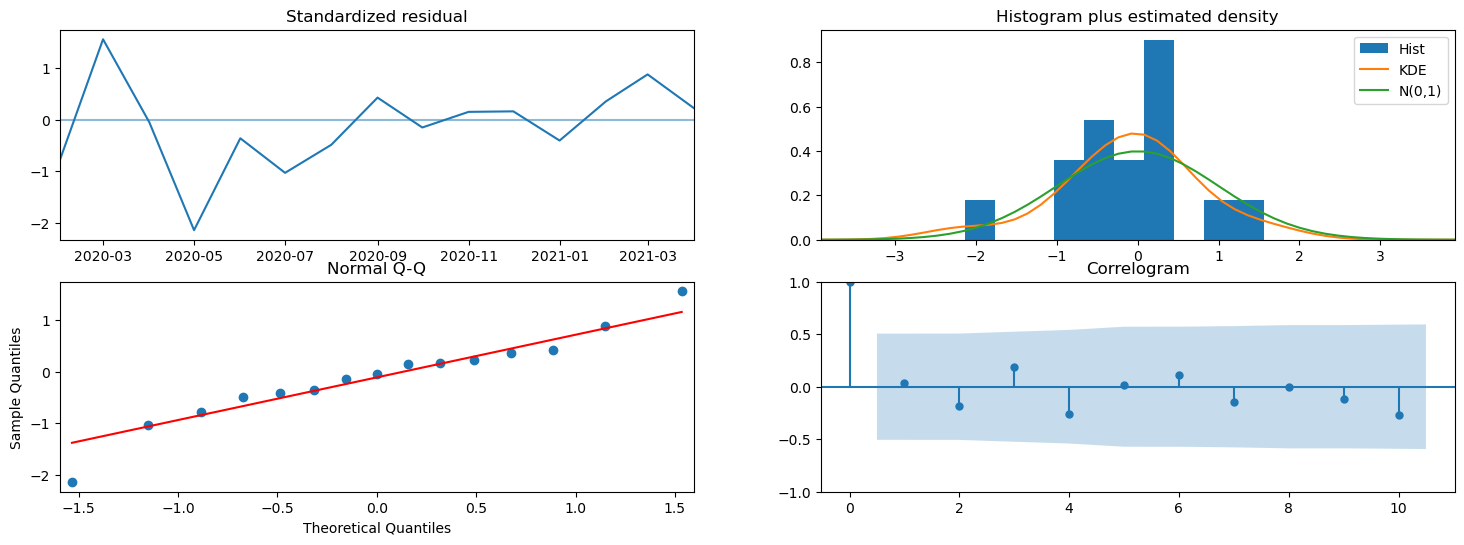

In [209]:
# Resíduo Filgrastim
stepwise_model_filgrastim.plot_diagnostics(figsize=(18,6))
plt.show()

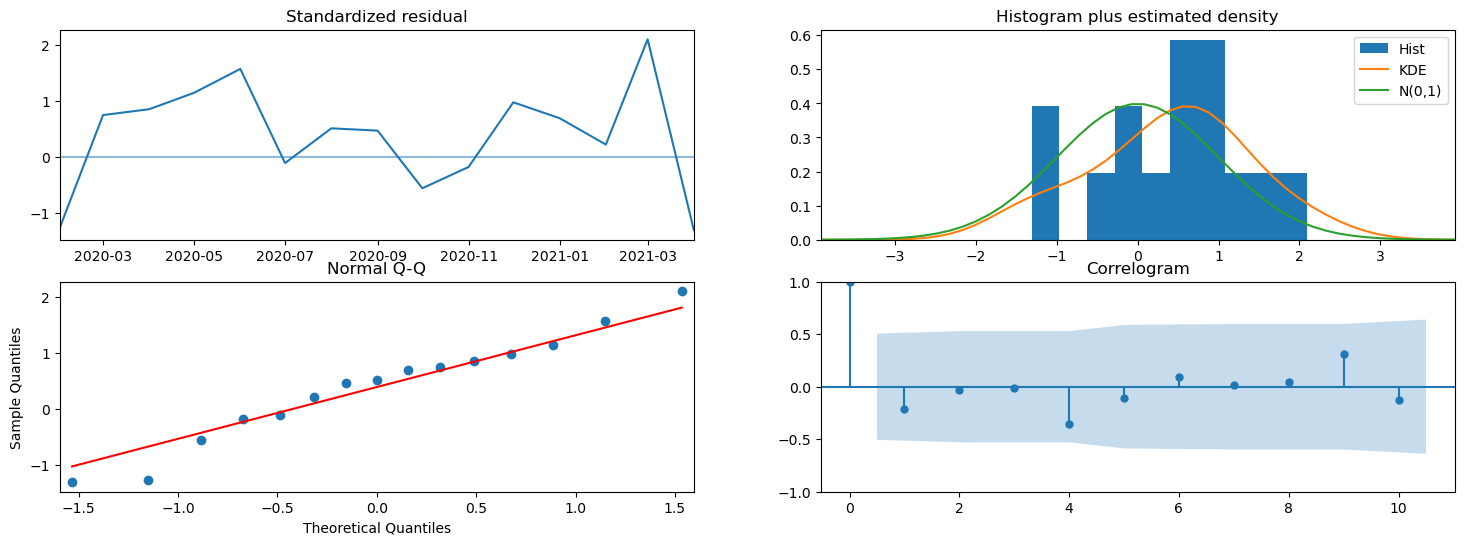

In [210]:
# Resíduo Golimumabe
stepwise_model_golimumabe.plot_diagnostics(figsize=(18,6))
plt.show()

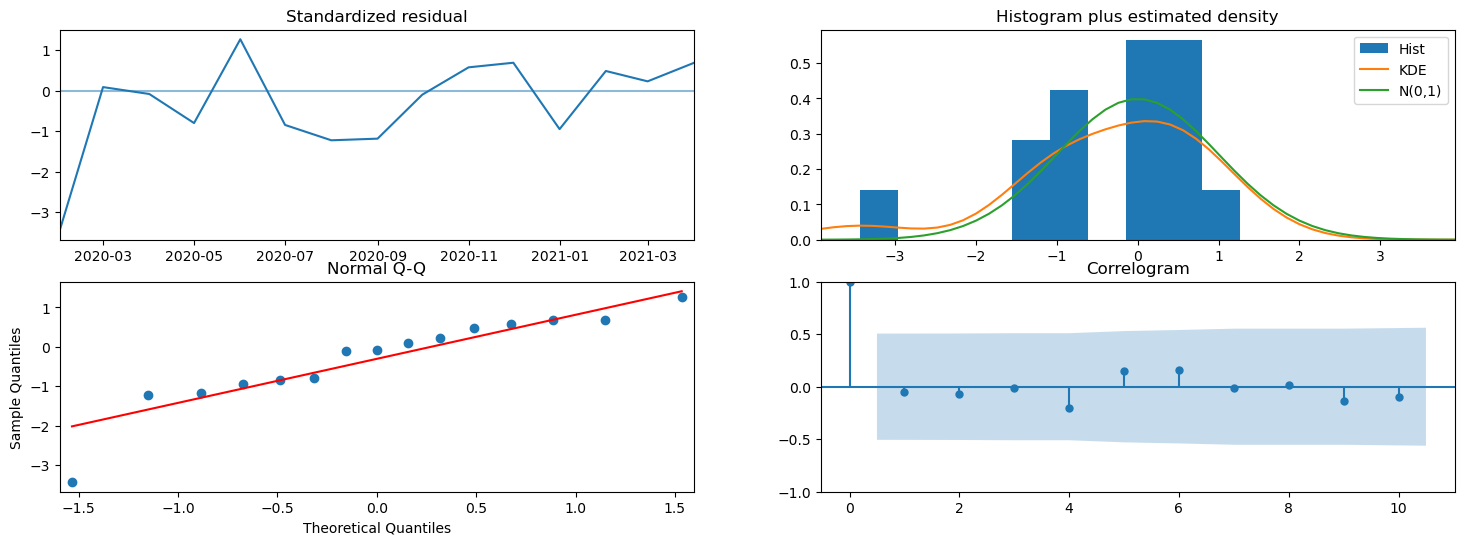

In [211]:
# Resíduo Imiglucerase
stepwise_model_imiglucerase.plot_diagnostics(figsize=(18,6))
plt.show()

## Predição

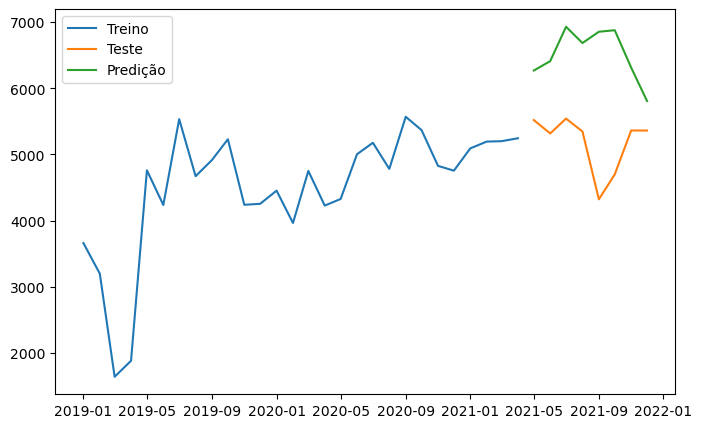

In [212]:
# Predição
stepwise_model_filgrastim.fit(train_filgrastim)
prediction_filgrastim = pd.DataFrame(stepwise_model_filgrastim.predict(n_periods=8), index=base_filgrastim.index)
prediction_filgrastim.columns = ['qtd_dispensada']

# Plot predição
plt.figure(figsize=(8,5))
plt.plot(train_filgrastim, label='Treino')
plt.plot(test_filgrastim, label='Teste')
plt.plot(prediction_filgrastim, label='Predição')
plt.legend()

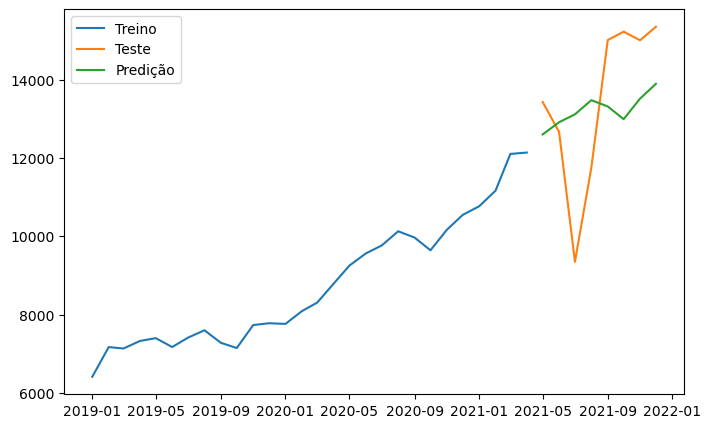

In [213]:
# Predição
stepwise_model_golimumabe.fit(train_golimumabe)
prediction_golimumabe = pd.DataFrame(stepwise_model_golimumabe.predict(n_periods=8), index=base_golimumabe.index)
prediction_golimumabe.columns = ['qtd_dispensada']

# Plot predição
plt.figure(figsize=(8,5))
plt.plot(train_golimumabe, label='Treino')
plt.plot(test_golimumabe, label='Teste')
plt.plot(prediction_golimumabe, label='Predição')
plt.legend()

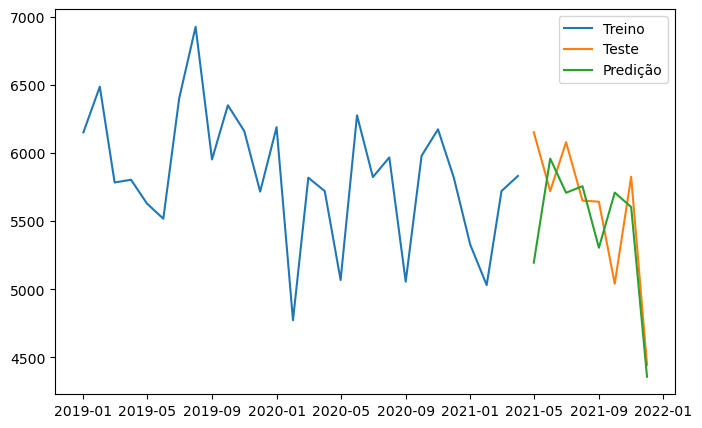

In [214]:
# Predição
stepwise_model_imiglucerase.fit(train_imiglucerase)
prediction_imiglucerase = pd.DataFrame(stepwise_model_imiglucerase.predict(n_periods=8), index=base_imiglucerase.index)
prediction_imiglucerase.columns = ['qtd_dispensada']

# Plot predição
plt.figure(figsize=(8,5))
plt.plot(train_imiglucerase, label='Treino')
plt.plot(test_imiglucerase, label='Teste')
plt.plot(prediction_imiglucerase, label='Predição')
plt.legend()

## Avaliação

As seguintes métricas foram calculadas para avaliação de cada predição:  
1- Mean Absolute Error (MAE);  
2- Mean Absolute Percentage Error (MAPE);  
3- Root Mean Squared Error (RMSE).  

In [215]:
# Função para calcular e apresentar as métricas de avaliação
def forecast_accuracy(teste, previsto, medicamento):
    mae =  metrics.mean_absolute_error(teste, previsto.dropna())
    mape = metrics.mean_absolute_percentage_error(teste, previsto.dropna())
    rmse = np.sqrt(metrics.mean_squared_error(teste, previsto.dropna()))

    print(medicamento)
    print('MAE: {:.4f}'.format(mae))
    print('MAPE: {:.4f}'.format(mape))
    print('RMSE: {:.4f}'.format(rmse))
    print('Modelo possui aproximadamente {:.1f}% de acurácia para prever os próximos oito meses.\n'.format(100-(mape*100)))

# Chamar a função para calcular as métricas de avaliação
forecast_accuracy(test_filgrastim, prediction_filgrastim, "Filgrastim")
forecast_accuracy(test_golimumabe, prediction_golimumabe, "Golimumabe")
forecast_accuracy(test_imiglucerase, prediction_imiglucerase, "Imiglucerase")

Filgrastim
MAE: 1335.1177
MAPE: 0.2691
RMSE: 1489.7211
Modelo possui aproximadamente 73.1% de acurácia para prever os próximos oito meses.

Golimumabe
MAE: 1679.0000
MAPE: 0.1355
RMSE: 1939.0730
Modelo possui aproximadamente 86.4% de acurácia para prever os próximos oito meses.

Imiglucerase
MAE: 373.6930
MAPE: 0.0659
RMSE: 466.5806
Modelo possui aproximadamente 93.4% de acurácia para prever os próximos oito meses.

